# __Algorithmic Trading: Execution Strategy__

In [203]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.75
plt.rcParams['axes.formatter.limits'] = [-6, 6]
plt.rcParams.update({'font.family': 'Times New Roman', 'mathtext.fontset': 'cm'})
plt.rcParams['figure.dpi'] = 120


In [204]:
message = pd.read_csv('AAPL_2012-06-21_34200000_57600000_message_10.csv', header=None)
orderbook = pd.read_csv('AAPL_2012-06-21_34200000_57600000_orderbook_10.csv', header=None)

Timestamp correction for the orderbook

In [205]:
orderbook.insert(0, 'Time', message[0])
orderbook['Time'] = pd.to_timedelta(orderbook['Time'], unit='s')
reference_date = pd.Timestamp('2012-06-21')
orderbook['Time'] = reference_date + orderbook['Time']

In [206]:
orderbook = orderbook[['Time',0,1,2,3]].copy() #We create a copy of the orderbook file to work with

We work with a dataframe useful to us with the columns that will be needed

In [207]:
orderbook.columns = ['Time','Ask Price 1','Ask Size 1','Bid Price 1','Bid Size 1'] #We rename the columns for better understanding

We conver the prices to dollars

In [208]:
orderbook.iloc[:,[1,3]]/=10000

Mid-Price for every snapshot

In [209]:
orderbook['Close MID'] = (orderbook['Ask Price 1'] + orderbook['Bid Price 1']) / 2 #We calculate the mid-price

We resample snapshots to 1 min and we take the close 'mid price'.

In [210]:
orderbook_resampled = orderbook.resample('60s', on='Time').agg({'Close MID':'last'}).reset_index()

We calculate the standard deviation and we check the first price value

In [211]:
my_stdev = orderbook_resampled['Close MID'].diff().std()
p_0 = orderbook_resampled['Close MID'].iloc[0]
print(F'The standard deviation is ${round(my_stdev, 2)}')
print(f'The midprice is ${round(p_0, 2)}')

The standard deviation is $0.28
The midprice is $585.51


## __Price simulator__

This chapter is only meant to visualize 5 simulations. Later on the price generator will be integrated in the models...

In [212]:
def price_simulator(p_0, my_stdev, s):
    for n in range(1, s + 1):
        prices = [p_0]
        for i in range(1, len(orderbook_resampled)):
            random_number = np.random.normal()
            price = prices[i - 1] + my_stdev * random_number
            prices.append(price)
        orderbook_resampled[f'Simulation {n}'] = prices
    return orderbook_resampled

In [213]:
orderbook_resampled = price_simulator(p_0, my_stdev, s=5)

In [214]:
fig = px.line(orderbook_resampled, x='Time', y=orderbook_resampled.columns, title=' Price Simulation')
fig.update_layout(yaxis_title="Price")
fig.show()

The coefficients and function for the Market Impact are given based on another analysis by Ziyad. The assumption is that the temporary market impact is a fuction s.t.:
$$MI_i=\sqrt{k_0 + kq_i}$$


In [215]:
k_0 =  -0.22220342210336297 ; k = 0.02759047485487536 #This numbers are not accurate, they are just for the example.

## __TWAP__ Implementation

In [216]:
def twap(Q,s, n=len(orderbook_resampled)):
    market_impact = np.sqrt(k_0 + k * Q/n)
    
    twap_df = pd.DataFrame(columns=['is_buy_twap', 'is_sell_twap'])
    
    for j in range(s):
        prices = [p_0]
        for i in range(len(orderbook_resampled)):
            random_number = np.random.normal()
            price = prices[i] + my_stdev * random_number
            prices.append(price)
        price_total = 1/n * sum(prices) 
    
        twap_df.loc[j,['is_buy_twap', 'is_sell_twap']] = [price_total + market_impact -p_0, price_total - market_impact -p_0]
    return twap_df

In [246]:
twap_df_1=twap(250000,300)
twap_df_2=twap(100000,300)
twap_df_3=twap(70000,300)

Nos creamos 4 subplots para 4 cantidades diferentes y vemos...

In [247]:
def histograms_twap(df,Q):
    data1 = df['is_buy_twap']
    data2 = df['is_sell_twap']

    mean1 = data1.mean()
    std1 = data1.std()

    mean2 = data2.mean()
    std2 = data2.std()

    fig, axs = plt.subplots(2, 1, figsize=(16, 8))

    axs[0].hist(data1, bins=20, color='skyblue', edgecolor='black')
    axs[0].set_title(f'TWAP Strategy Buy for $Q={Q//1000}$k')
    axs[0].set_xlabel('$IS$ metric')
    axs[0].set_ylabel('Frecuency')
    axs[0].text(0.95, 0.95, f'$\mu$: {mean1:.2f}\n$\sigma$: {std1:.2f}', ha='right', va='top', transform=axs[0].transAxes, bbox=dict(facecolor='white', alpha=1),fontsize=15)

    axs[1].hist(data2, bins=30, color='salmon', edgecolor='black')
    axs[1].set_title(f'TWAP Strategy Sell for $Q={Q//1000}$k')
    axs[1].set_xlabel('$IS$ metric')
    axs[1].set_ylabel('Frecuency')

    axs[1].text(0.95, 0.95, f'$\mu$: {mean2:.2f}\n$\sigma$: {std2:.2f}', ha='right', va='top', transform=axs[1].transAxes, bbox=dict(facecolor='white', alpha=1),fontsize=15)
    plt.tight_layout()
    plt.show()

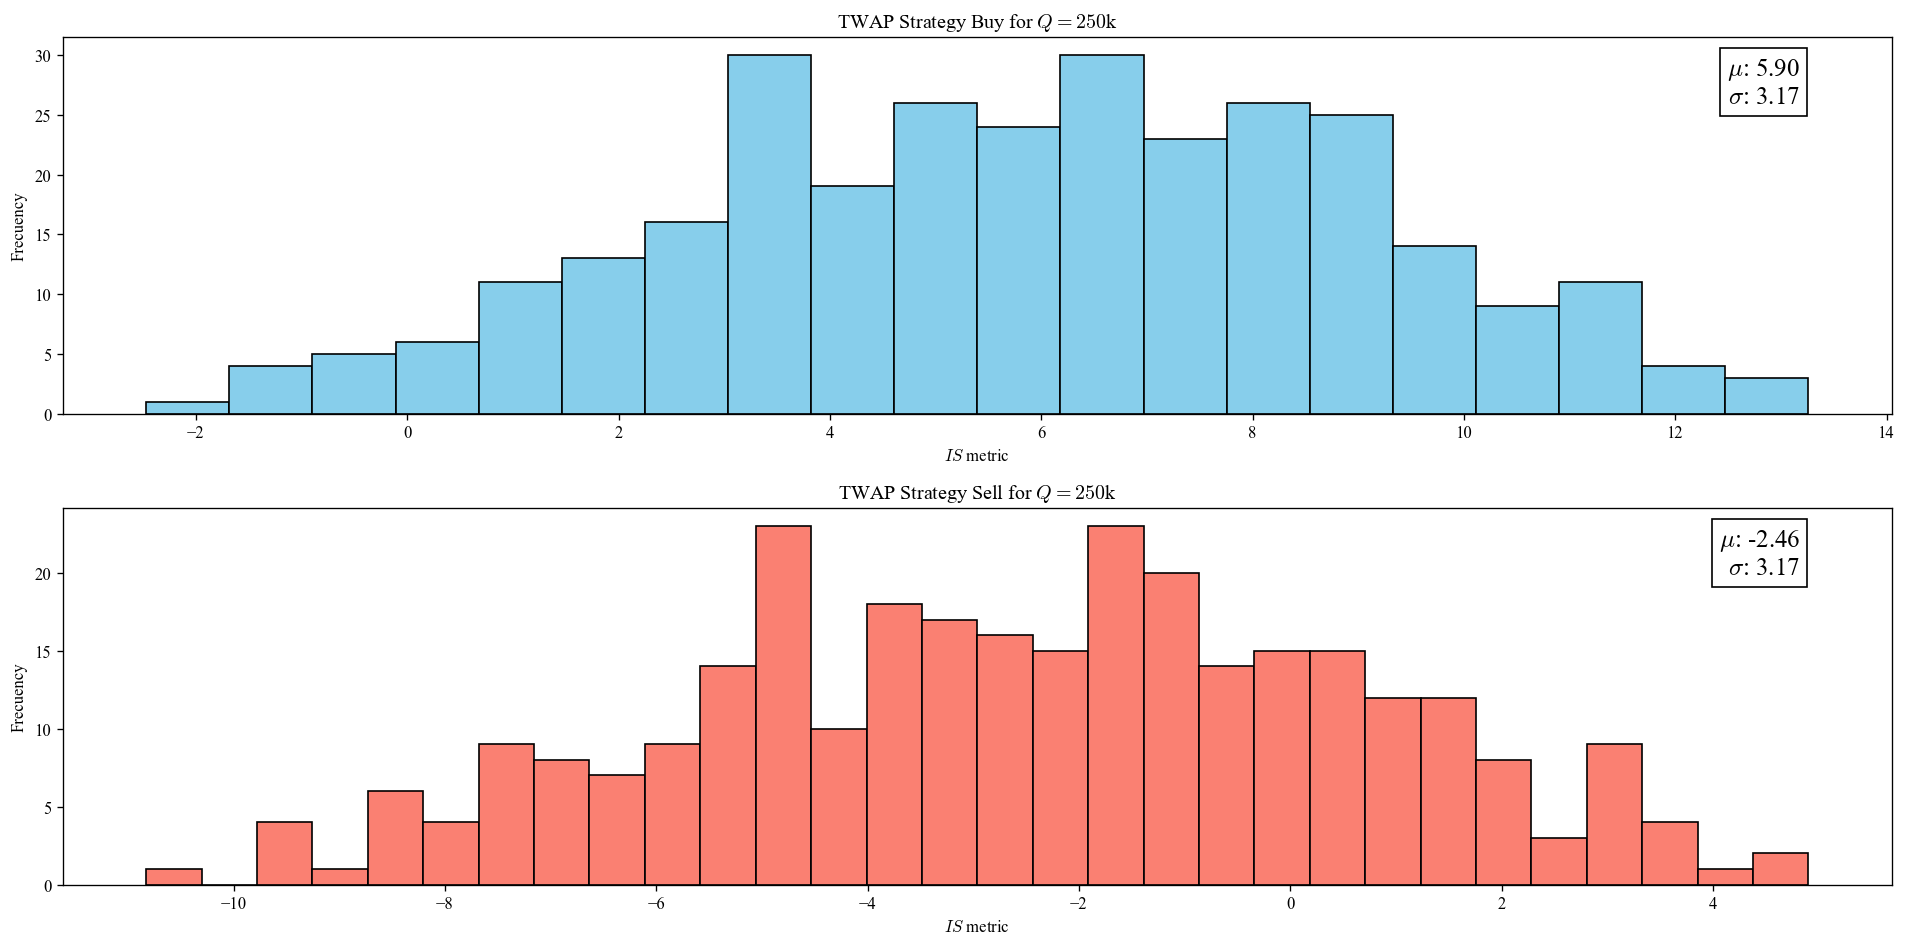

In [248]:
histograms_twap(twap_df_1,250000)

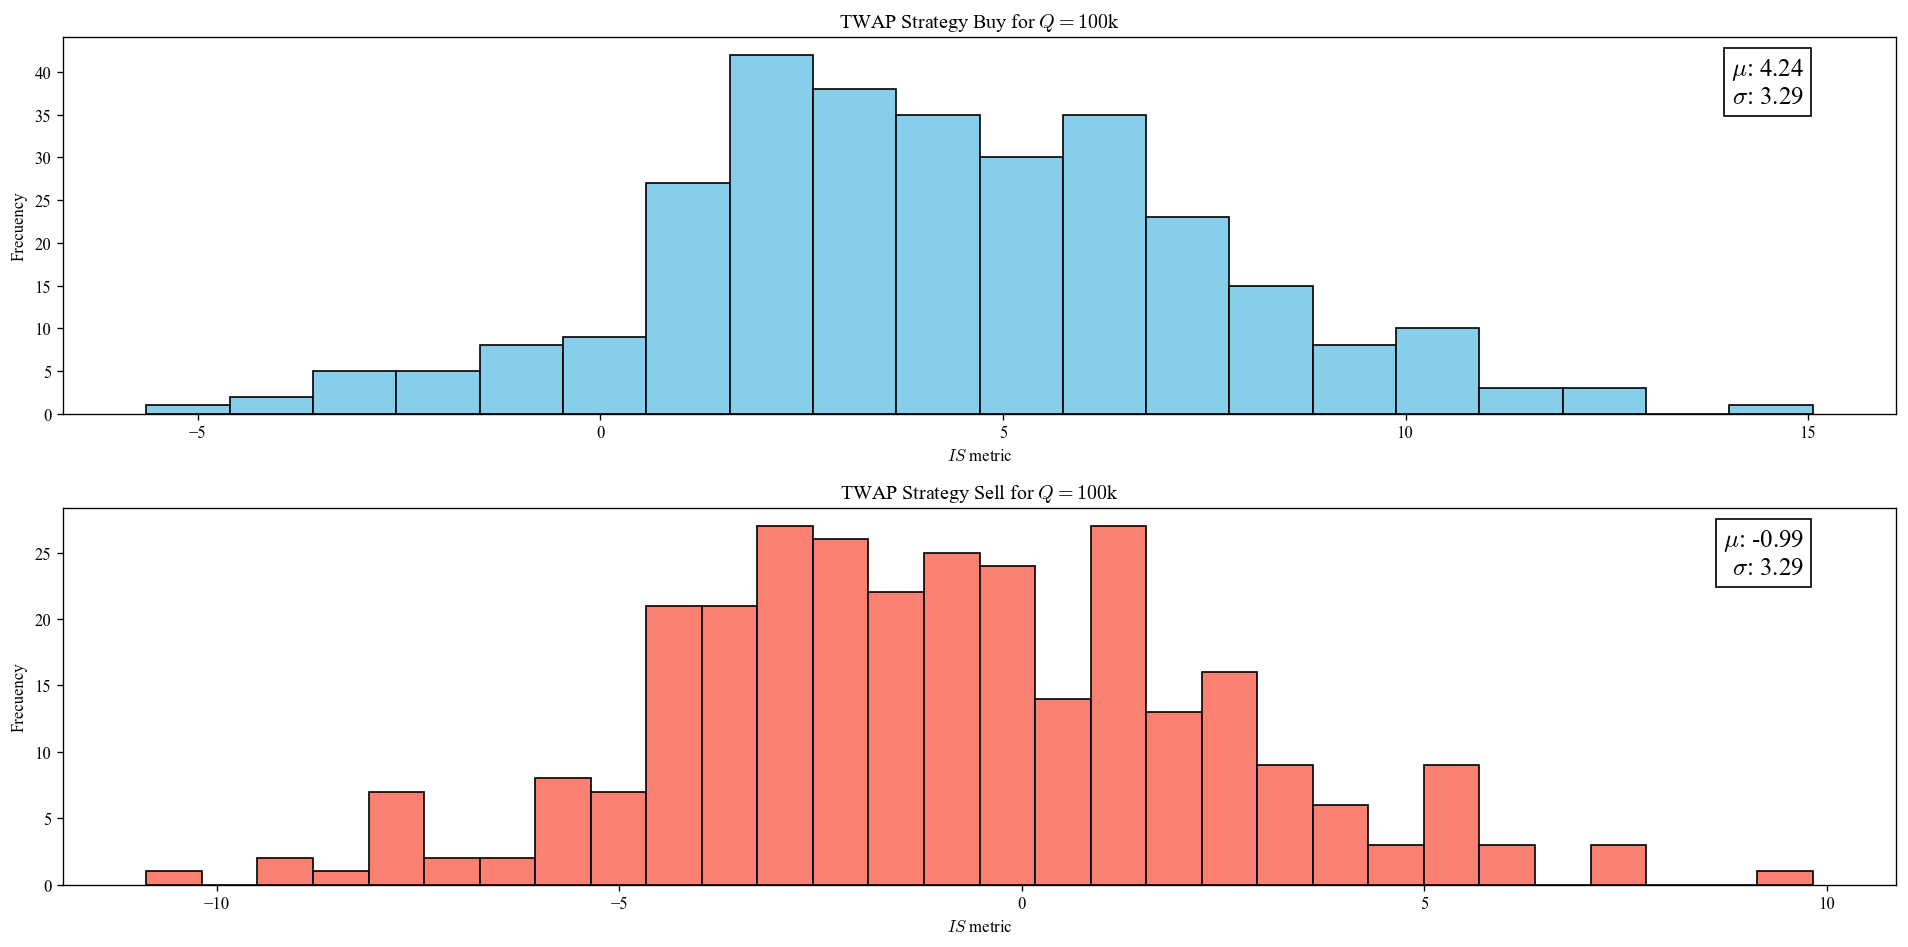

In [249]:
histograms_twap(twap_df_2,100000)

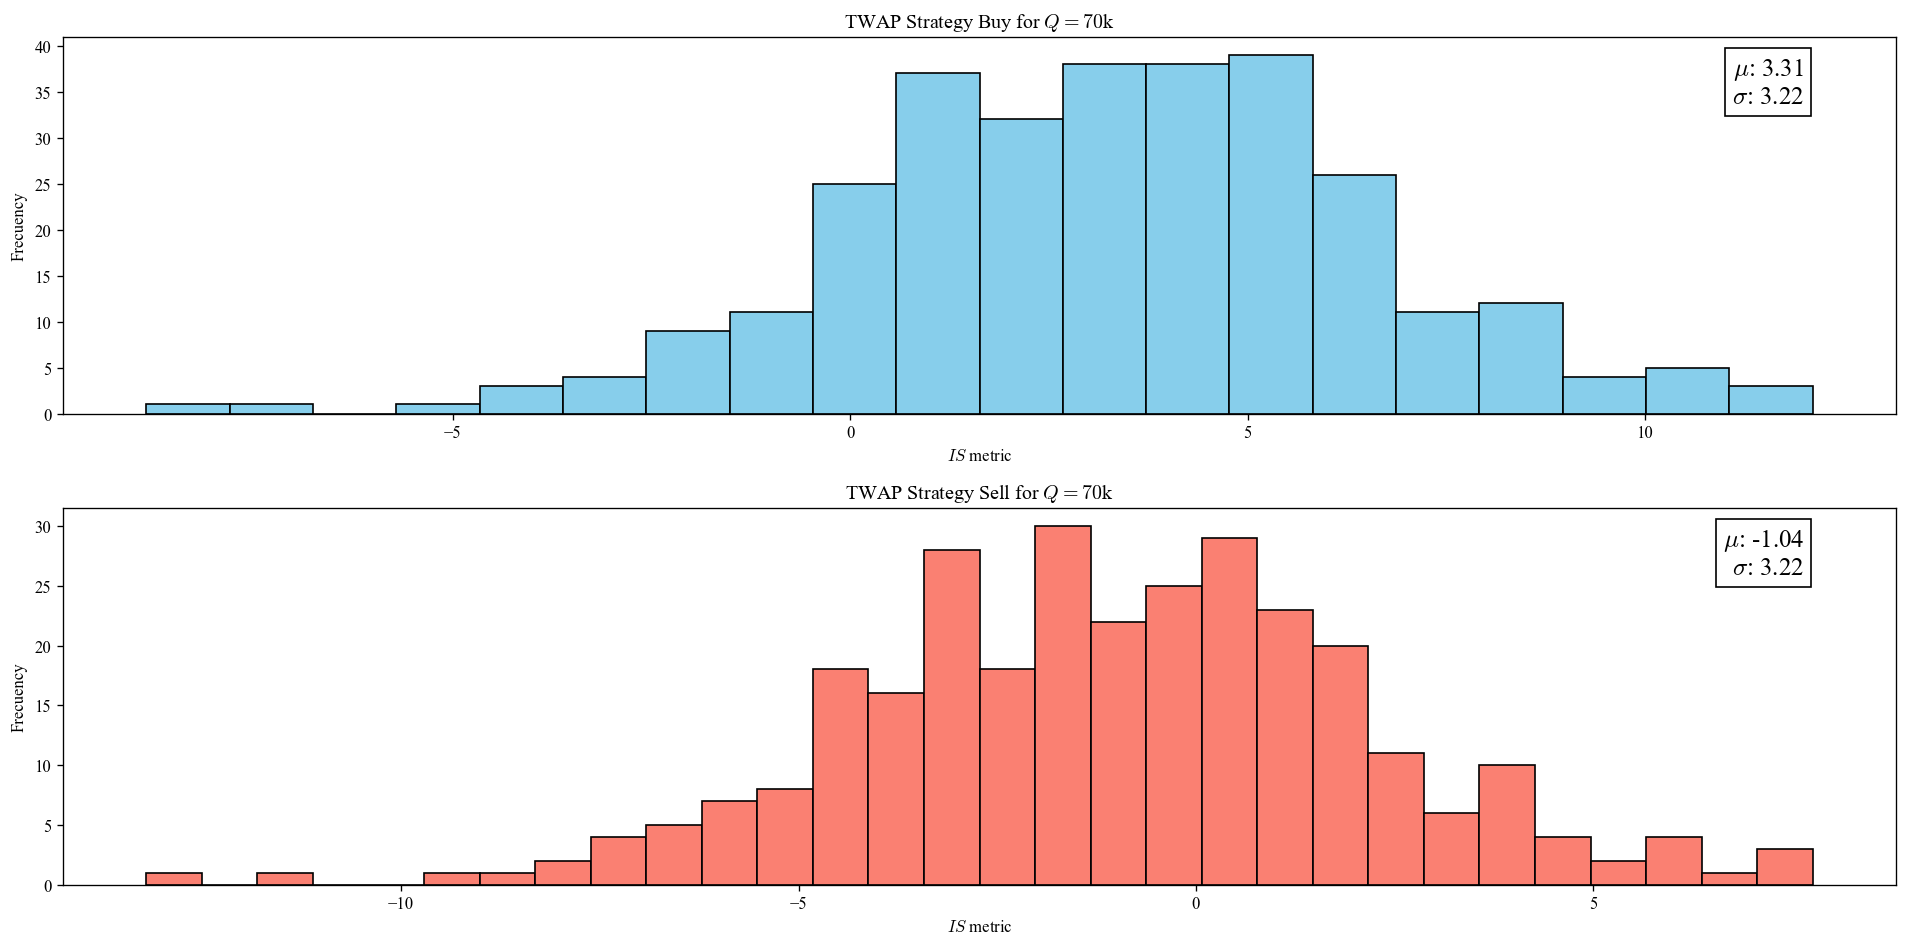

In [250]:
histograms_twap(twap_df_3,70000)

## __Implementation Shortfall__

In this last section, we study the strategy for Implementation Shortfall. We start by defining the function that will give depending on the total quantity and the risk advisory ($\lambda$) term, the Implementation Shortfall (IS) Metric. Before that also, we'll take another approach on how to spread the volume in time, which can be seen in the current cell. Depending on the risk advisory term, the smaller it gets the more it resembles to the partion in the TWAP Implementation.

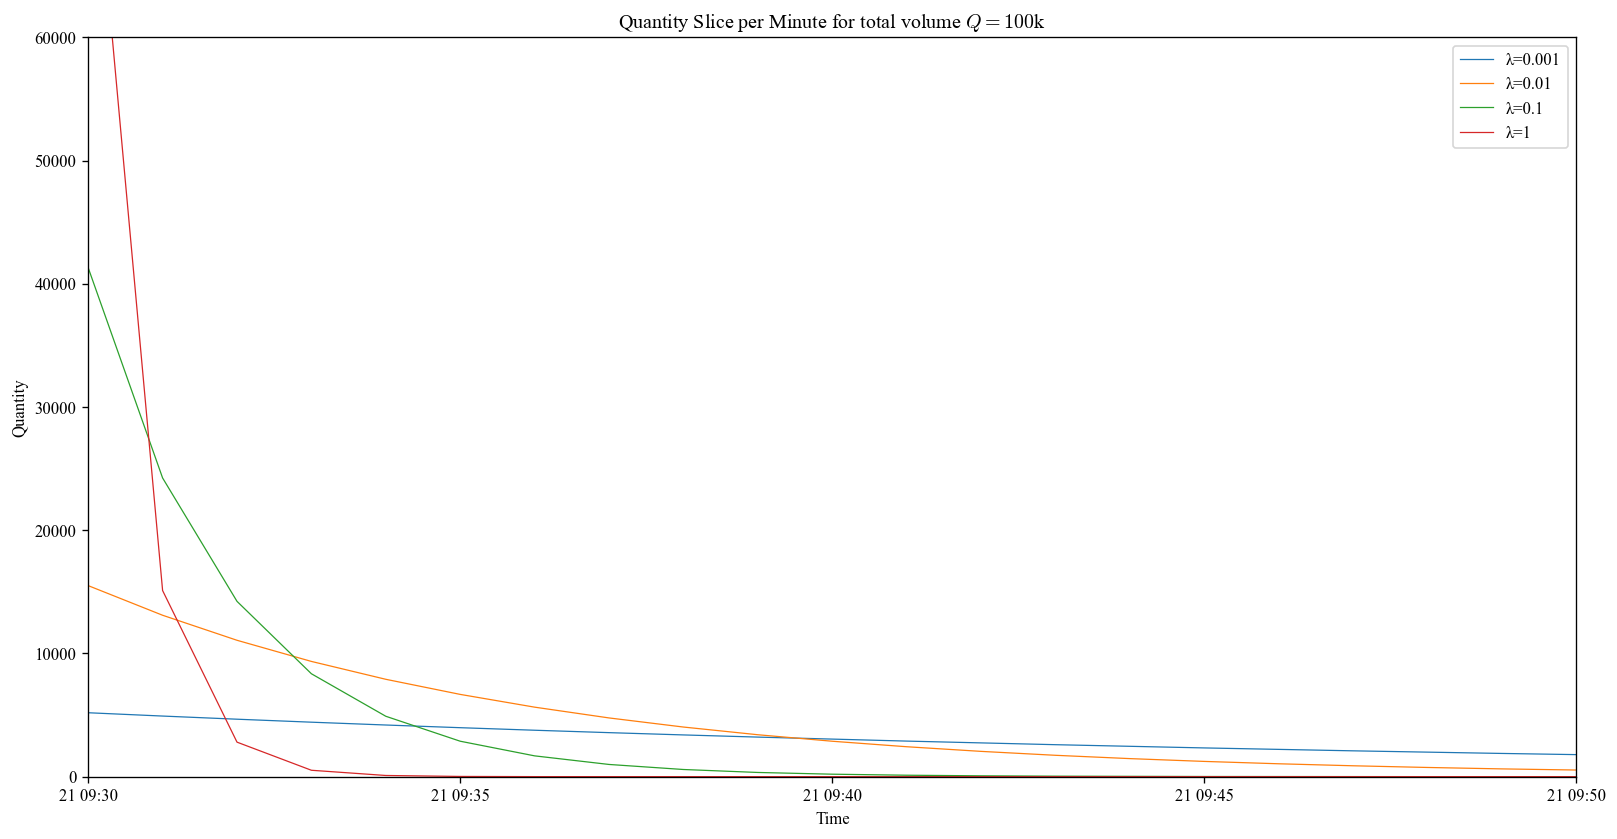

In [251]:
def plot_quantities(n, Q):
    T = len(orderbook_resampled)
    λ_values = [0.001,0.01,0.1,1]
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    for i, λ in enumerate(λ_values, 1):
        x = np.sqrt(λ * my_stdev**2 / k)
        quantities = []
        
        for j in range(len(orderbook_resampled)):
            q_j = Q * (np.sinh(x*(T-j)) - np.sinh(x*(T-j-1))) / np.sinh(x*T)
            quantities.append(q_j)
        
        ax.plot(orderbook_resampled['Time'], quantities, label=f'λ={λ}')

    ax.set_title('Quantity Slice per Minute for total volume $Q=100$k')
    ax.set_xlabel('Time')
    ax.set_ylabel('Quantity')
    ax.set_xlim(orderbook_resampled['Time'].iloc[0], orderbook_resampled['Time'].iloc[20])
    ax.set_ylim(0, 60000)
    ax.legend()
    plt.show()

# Example usage:
plot_quantities(4, 100000)

In [165]:
def shorfall_implementation(Q,λ,s,n=len(orderbook_resampled)):
    x=np.sqrt(λ*my_stdev**2/k)
       
    is_df = pd.DataFrame(columns=['is_buy_is', 'is_sell_is'])
    
    for i in range(s):
        prices = np.array([p_0])
        quantity = np.array([])
        function = np.array([])
        
        for j in range(len(orderbook_resampled)):           
            
            T = len(orderbook_resampled)
            q_j = Q * (np.sinh(x*(T-j)) - np.sinh(x*(T-j-1))) / np.sinh(x*T)
            quantity = np.append(quantity, q_j)
            
            if k_0 + k * q_j < 0:
                function = np.append(function, 0)
                
            else:
                function = np.append(function, np.sqrt(k_0 + k * q_j))
            
        #radom prices
        for h in range(1,len(orderbook_resampled)):
            random_number = np.random.normal()
            price = prices[h-1] + my_stdev * random_number
            prices = np.append(prices,price)
            
        #Total price    
        price_total = prices.dot(quantity)
        market_impact = quantity.dot(function)
        buy_shortfall = (price_total + market_impact)/Q
        sell_shortfall = (price_total - market_impact)/Q

        is_df.loc[i,['is_buy_is', 'is_sell_is']] = [buy_shortfall-p_0, sell_shortfall-p_0]
    return is_df

In [253]:
is_df_1= shorfall_implementation(250000, 0.01, 300) #s maximum as the total number of price simulations
is_df_2= shorfall_implementation(250000, 1, 300)

is_df_3= shorfall_implementation(100000, 0.01, 300)
id_df_4= shorfall_implementation(100000, 1, 300)

We define a function to later have all the histogram plots

In [254]:
def histograms_is(df,Q,λ):
    data1 = df['is_buy_is']
    data2 = df['is_sell_is']

    mean1 = data1.mean()
    std1 = data1.std()

    mean2 = data2.mean()
    std2 = data2.std()

    fig, axs = plt.subplots(2, 1, figsize=(16, 8))

    axs[0].hist(data1, bins=20, color='skyblue', edgecolor='black')
    axs[0].set_title(f'Implementation Shortfall Buy for $Q={Q}$k & $\lambda={λ}$')
    axs[0].set_xlabel('$IS$ metric')
    axs[0].set_ylabel('Frecuency')
    axs[0].text(0.95, 0.95, f'$\mu$: {mean1:.2f}\n$\sigma$: {std1:.2f}', ha='right', va='top', transform=axs[0].transAxes, bbox=dict(facecolor='white', alpha=1),fontsize=15)

    axs[1].hist(data2, bins=30, color='salmon', edgecolor='black')
    axs[1].set_title(f'Implementation Shortfall Sell for $Q={Q}$k & $\lambda={λ}$')
    axs[1].set_xlabel('$IS$ metric')
    axs[1].set_ylabel('Frecuency')

    axs[1].text(0.95, 0.95, f'$\mu$: {mean2:.2f}\n$\sigma$: {std2:.2f}', ha='right', va='top', transform=axs[1].transAxes, bbox=dict(facecolor='white', alpha=1),fontsize=15)
    plt.tight_layout()
    plt.show()

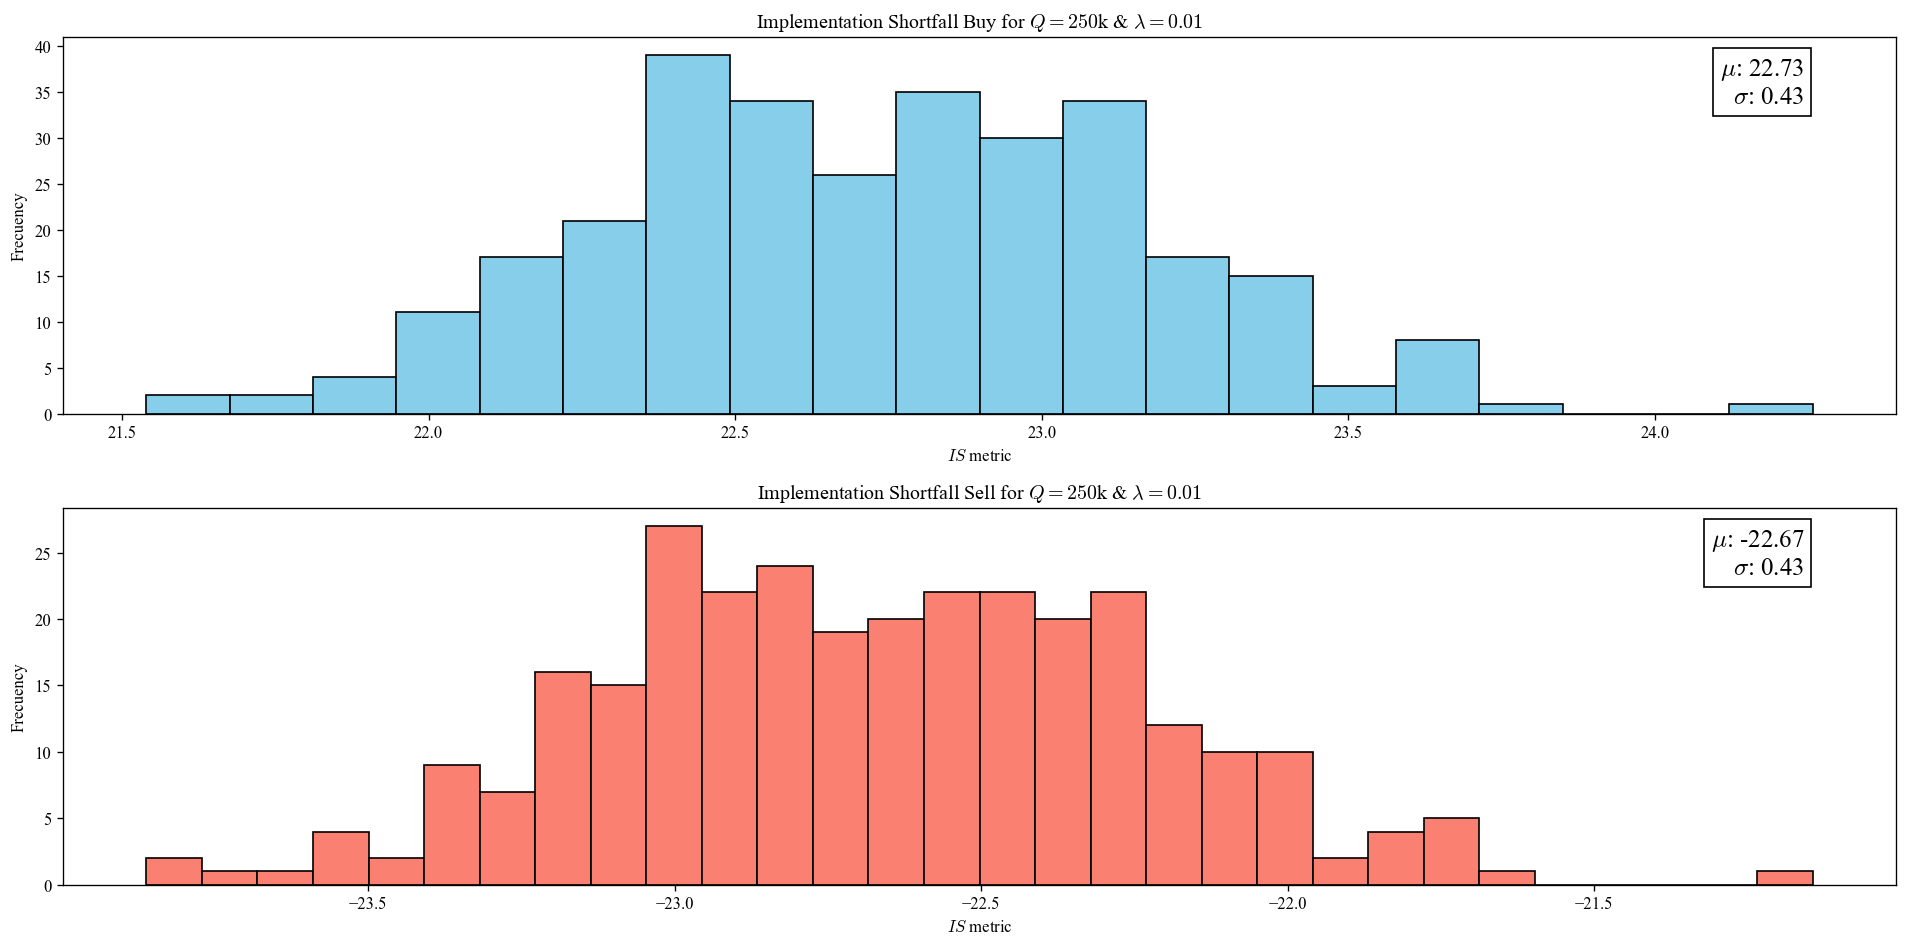

In [255]:
histograms_is(is_df_1,250,0.01)

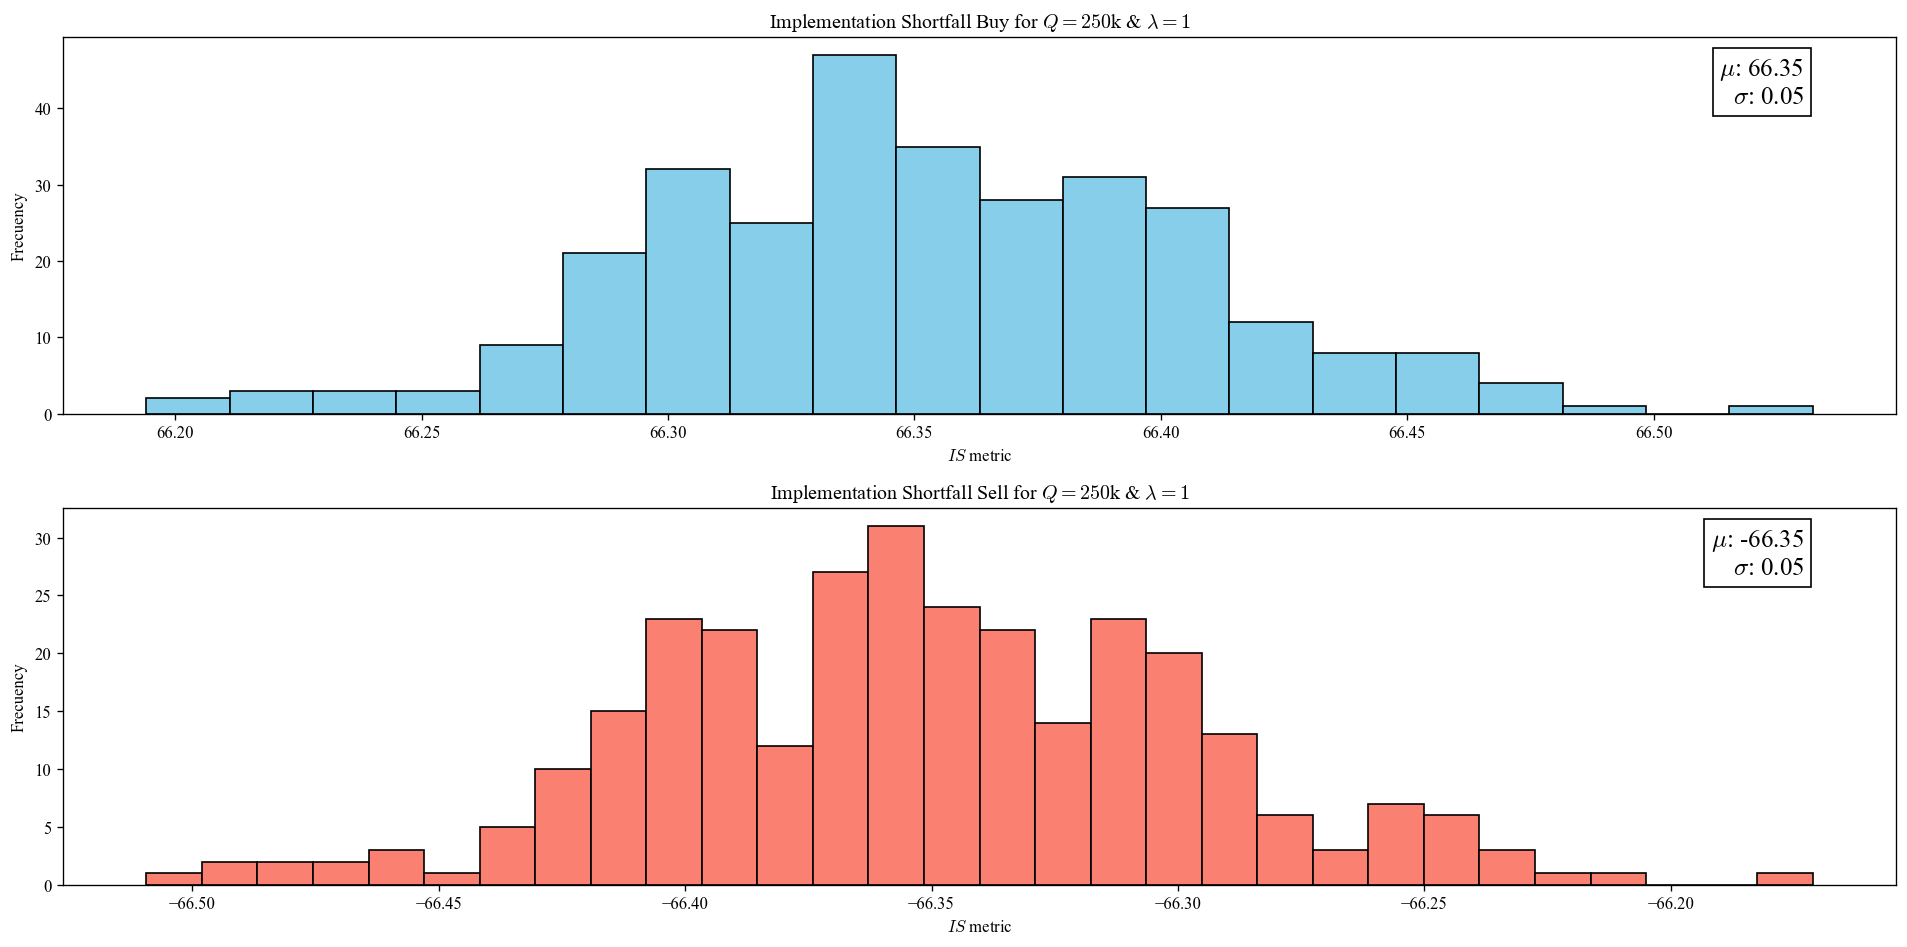

In [256]:
histograms_is(is_df_2,250,1)

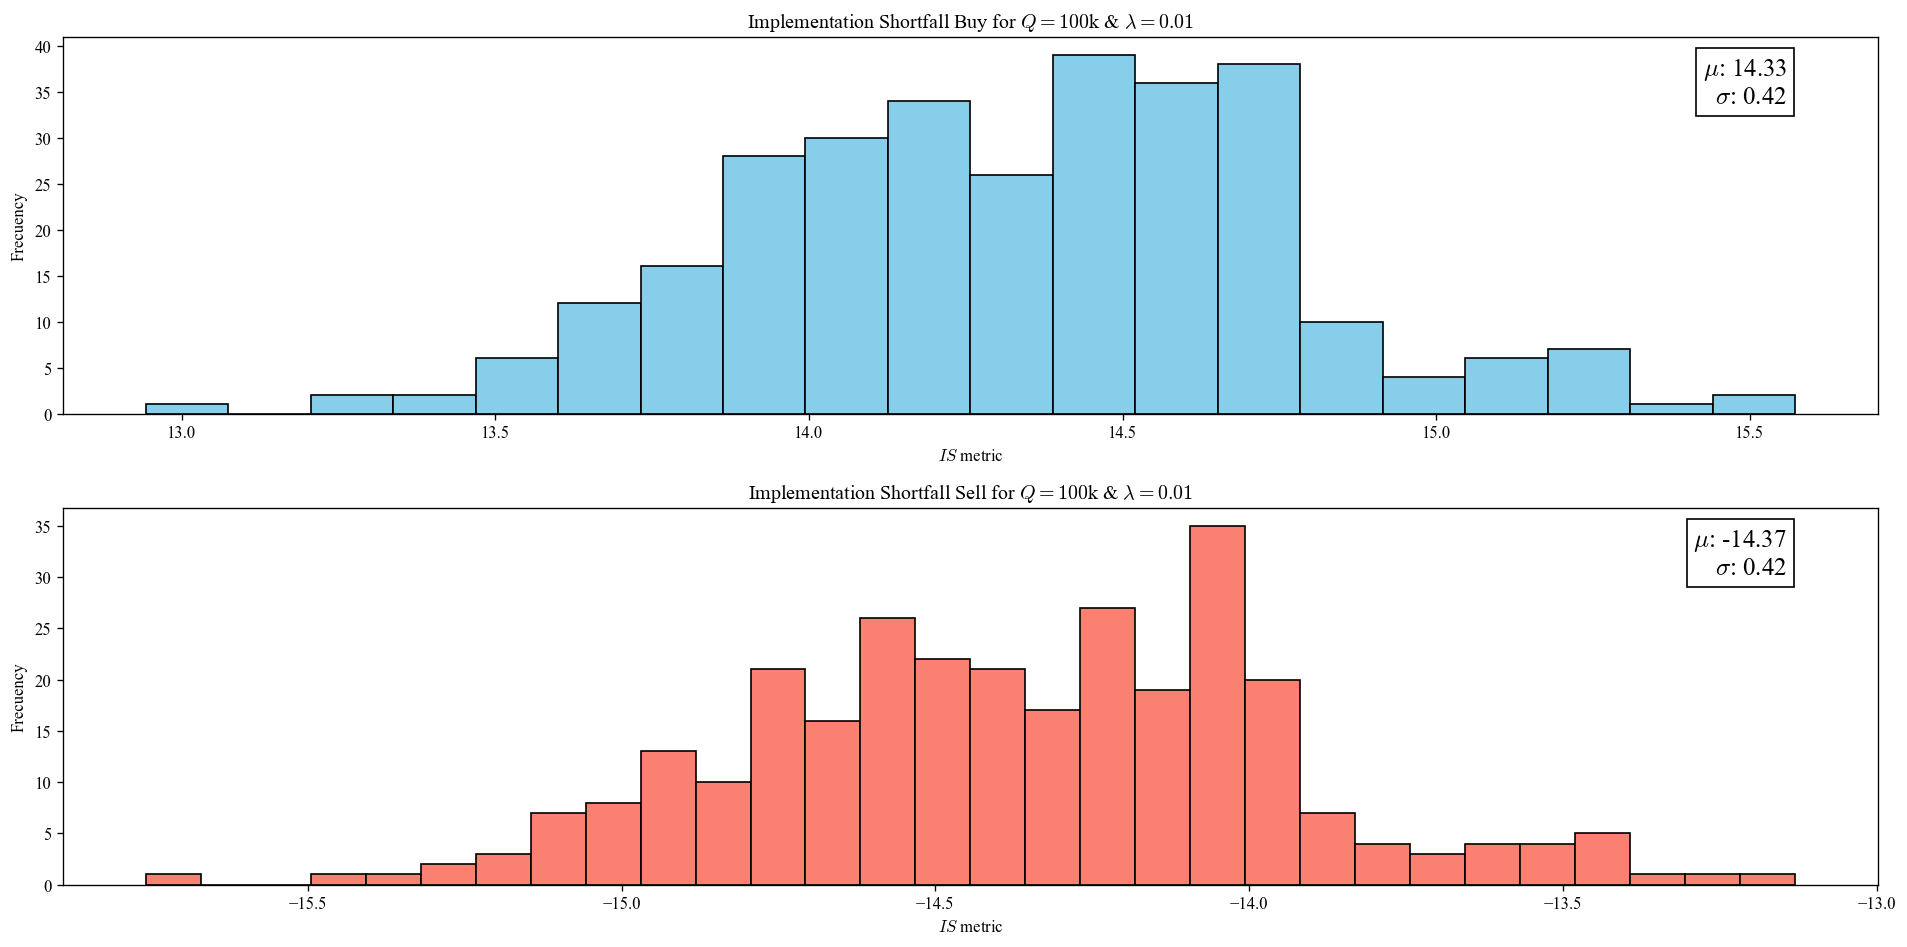

In [257]:
histograms_is(is_df_3,100,0.01)

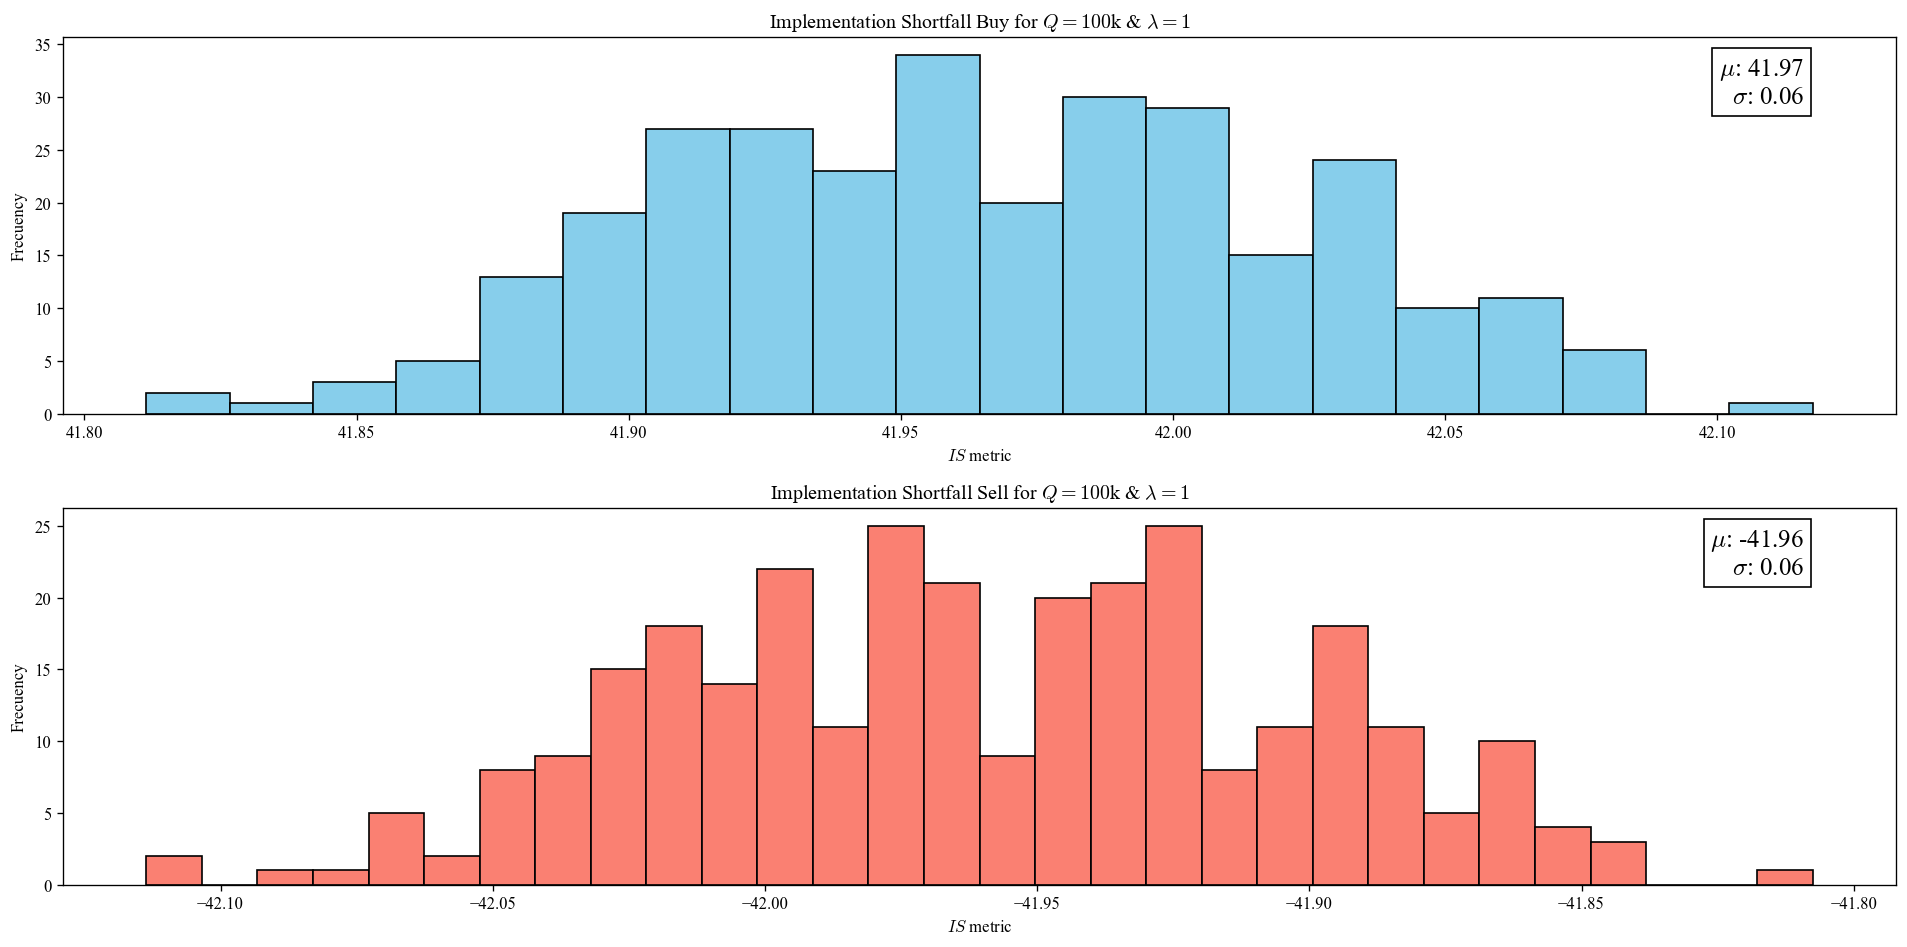

In [262]:
histograms_is(id_df_4,100,1)

Total volume

In [ ]:
executed_trades = message[(message[1] == 4) | (message[1] == 5)]

# Separate buy and sell trades
buy_trades = executed_trades[executed_trades[5] == 1]
sell_trades = executed_trades[executed_trades[5] == -1]

# Calculate the total volume traded during the day for both buy and sell trades
total_buy_volume = buy_trades[3].sum()
total_sell_volume = sell_trades[3].sum()

print("Total buy volume traded during the day:", total_buy_volume)
print("Total sell volume traded during the day:", total_sell_volume)
print("Total volume traded during the day:", total_buy_volume + total_sell_volume)

Total buy volume traded during the day: 1535804
Total sell volume traded during the day: 1314336
Total volume traded during the day: 2850140
